In [3]:
import pandas as pd

from pandas_datareader import data as pdr

import yfinance as yf
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import scipy.stats as st

# Create our portfolio of equities
tickers = ['LYG','BP', 'RYCEY']
 
# Set the investment weights (I arbitrarily picked for example)
weights = np.array([.333, .333, .333])
 
# Set an initial investment level
initial_investment = 10000
 
# Download closing prices
data = pdr.get_data_yahoo(tickers, start="2018-01-01", end=dt.date.today())['Adj Close']
 
#From the closing prices, calculate periodic returns

#Simple Return

returns = data.pct_change().dropna()

#log return

#returns = np.log(data/data.shift(1)).dropna()

returns.head(5)

Symbols,LYG,BP,RYCEY
Date,,,
2018-01-03,-0.013227,0.011562,0.006114
2018-01-04,0.010724,0.003965,0.012153
2018-01-05,0.002653,0.001394,0.001715
2018-01-08,0.000000,-0.000464,0.010274
2018-01-09,0.002645,-0.004874,-0.007627


In [4]:
# Generate Var-Cov matrix
cov_matrix = returns.cov()
cov_matrix

Symbols,LYG,BP,RYCEY
Symbols,,,
LYG,0.000667,0.000356,0.000474
BP,0.000356,0.000565,0.000363
RYCEY,0.000474,0.000363,0.001433


In [5]:
# Calculate mean returns for each stock
avg_rets = returns.mean()
 
# Calculate mean returns for portfolio overall, 
# using dot product to 
# normalize individual means against investment weights
 # https://en.wikipedia.org/wiki/Dot_product#:~:targetText=In%20mathematics%2C%20the%20dot%20product,and%20returns%20a%20single%20number.
port_mean = avg_rets.dot(weights)


In [6]:
print(avg_rets)
print(port_mean)

Symbols
LYG      0.000004
BP       0.000025
RYCEY   -0.001244
dtype: float64
-0.00040474009622513236


In [7]:
port_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

mean_investment = initial_investment * (1 + port_mean)

investment_std = mean_investment * port_std

print(mean_investment)

print(investment_std)

9995.952599037748
236.58022509654208


In [8]:
critical_level = 0.05

from scipy.stats import norm

cutoff1 = norm.ppf(critical_level, mean_investment, investment_std)

cutoff1

9606.812757722704

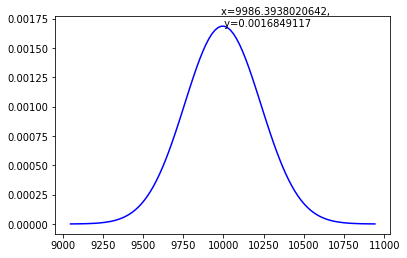

In [9]:
fig, ax = plt.subplots()

x= np.linspace(mean_investment - 4* investment_std, mean_investment + 4*investment_std,100)

y = norm.pdf(x, mean_investment, investment_std,  )

ax.plot(x,y,'b-', label='norm pdf')



ymax = max(y)
xmax = x[np.argmax(y)]

text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)


ax.annotate(text, xy=(xmax, ymax))
plt.show()
                                                                         

In [10]:
var_1d = np.round(initial_investment - cutoff1 , 2)
var_1d

393.19

1 day VaR @ 95% confidence: 393.19
2 day VaR @ 95% confidence: 556.05
3 day VaR @ 95% confidence: 681.03
4 day VaR @ 95% confidence: 786.38
5 day VaR @ 95% confidence: 879.2
6 day VaR @ 95% confidence: 963.11
7 day VaR @ 95% confidence: 1040.28
8 day VaR @ 95% confidence: 1112.11
9 day VaR @ 95% confidence: 1179.57
10 day VaR @ 95% confidence: 1243.38
11 day VaR @ 95% confidence: 1304.06
12 day VaR @ 95% confidence: 1362.05
13 day VaR @ 95% confidence: 1417.67
14 day VaR @ 95% confidence: 1471.18
15 day VaR @ 95% confidence: 1522.82


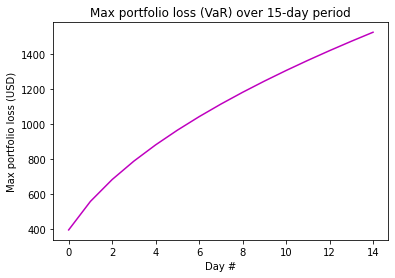

In [11]:
# Calculate n Day VaR
var_array = []
num_days = 15
for x in range(1,num_days+1):    
    var_array.append(np.round(var_1d * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "m")

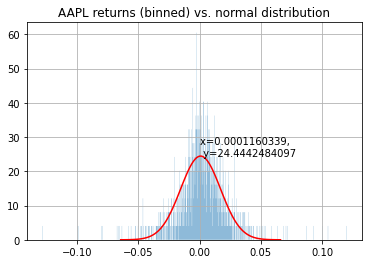

NormaltestResult(statistic=131.08565761921133, pvalue=3.428554991796059e-29)

In [37]:

# Repeat for each equity in portfolio

fig, ax = plt.subplots()

returns['AAPL'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("AAPL returns (binned) vs. normal distribution")

ymax = max(norm.pdf(x, port_mean, port_std))
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

plt.show()

st.normaltest(returns['AAPL'], nan_policy='omit')

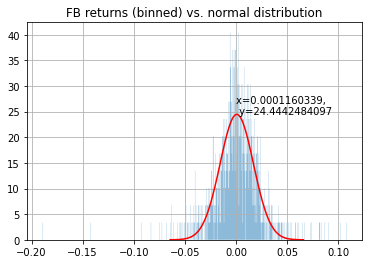

NormaltestResult(statistic=219.54054075960266, pvalue=2.1250898501645215e-48)

In [38]:
fig, ax = plt.subplots()

returns['FB'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("FB returns (binned) vs. normal distribution")

ymax = max(norm.pdf(x, port_mean, port_std))
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))
plt.show()

st.normaltest(returns['FB'], nan_policy='omit')

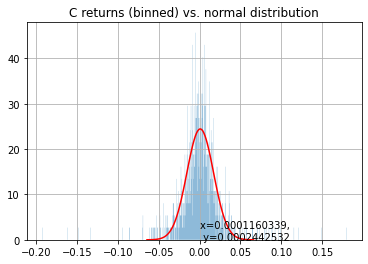

NormaltestResult(statistic=209.61363964655996, pvalue=3.040720379984774e-46)

In [39]:
fig, ax = plt.subplots()

returns['C'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("C returns (binned) vs. normal distribution")

ymax = max(y)
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

plt.show()

st.normaltest(returns['C'], nan_policy='omit')

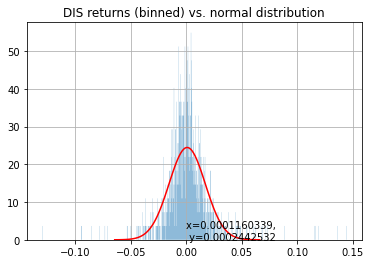

NormaltestResult(statistic=299.59644880126507, pvalue=8.77925662296656e-66)

In [40]:
fig, ax = plt.subplots()

returns['DIS'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("DIS returns (binned) vs. normal distribution")

ymax = max(y)
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

plt.show()

st.normaltest(returns['DIS'], nan_policy='omit')

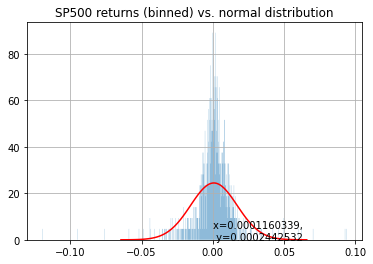

NormaltestResult(statistic=304.8081173376744, pvalue=6.482735470283858e-67)

In [41]:
fig, ax = plt.subplots()

returns['^GSPC'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("SP500 returns (binned) vs. normal distribution")

ymax = max(y)
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

plt.show()

st.normaltest(returns['^GSPC'], nan_policy='omit')

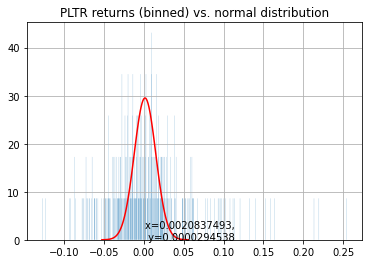

NormaltestResult(statistic=94.80832851778062, pvalue=2.586026929800276e-21)

In [15]:
fig, ax = plt.subplots()

returns['PLTR'].hist(bins=1000,histtype="stepfilled",alpha=0.5, density = True)

x = np.linspace(port_mean - 4*port_std, port_mean + 4*port_std , 100)
plt.plot(x, norm.pdf(x, port_mean, port_std), "r")
plt.title("PLTR returns (binned) vs. normal distribution")

ymax = max(y)
xmax = x[np.argmax(y)]
text= "x={:.10f}, \n y={:.10f}".format(xmax, ymax)
ax.annotate(text, xy=(xmax, ymax))

plt.show()

st.normaltest(returns['PLTR'], nan_policy='omit')

NormaltestResult(statistic=252.0612602341359, pvalue=1.84328627499519e-55)

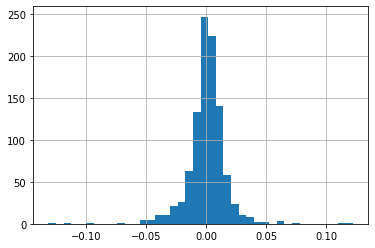

In [44]:
port = returns.dot(weights)


fig, ax = plt.subplots()

port.hist(bins = 40)


st.normaltest(port, axis = 0, nan_policy='omit')